# Pulsation MCMC for Potential Exoplanet (TESS)

## Import Libraries

In [1]:
import numpy as np
from astropy.io import ascii
from astropy.io import fits
from astropy.timeseries import LombScargle
from scipy.optimize import minimize
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams; rcParams["figure.dpi"] = 300
from astropy.table import Table, Column
from scipy.stats import norm
import math
import emcee
import batman
import corner

## Initial Pulsation Observations
- Import and extract Data from Transit Observations (flux_info.dat)
- Plot Residual Fluxes v/s Time Lightcurve
- Plot Lomb-Scargle Periodogram

In [2]:
# Import and extract Data from Transit Observations (flux_info.dat)
table = ascii.read('flux_info.dat')
rel_flux_new = table['Relative_Flux']
rel_flux_err_new = table['Relative_Flux_Err']
rel_flux_fit = table['Relative_Flux_Fit']
flux_residuals = table['Flux_Residuals']
time_new = table['Time']

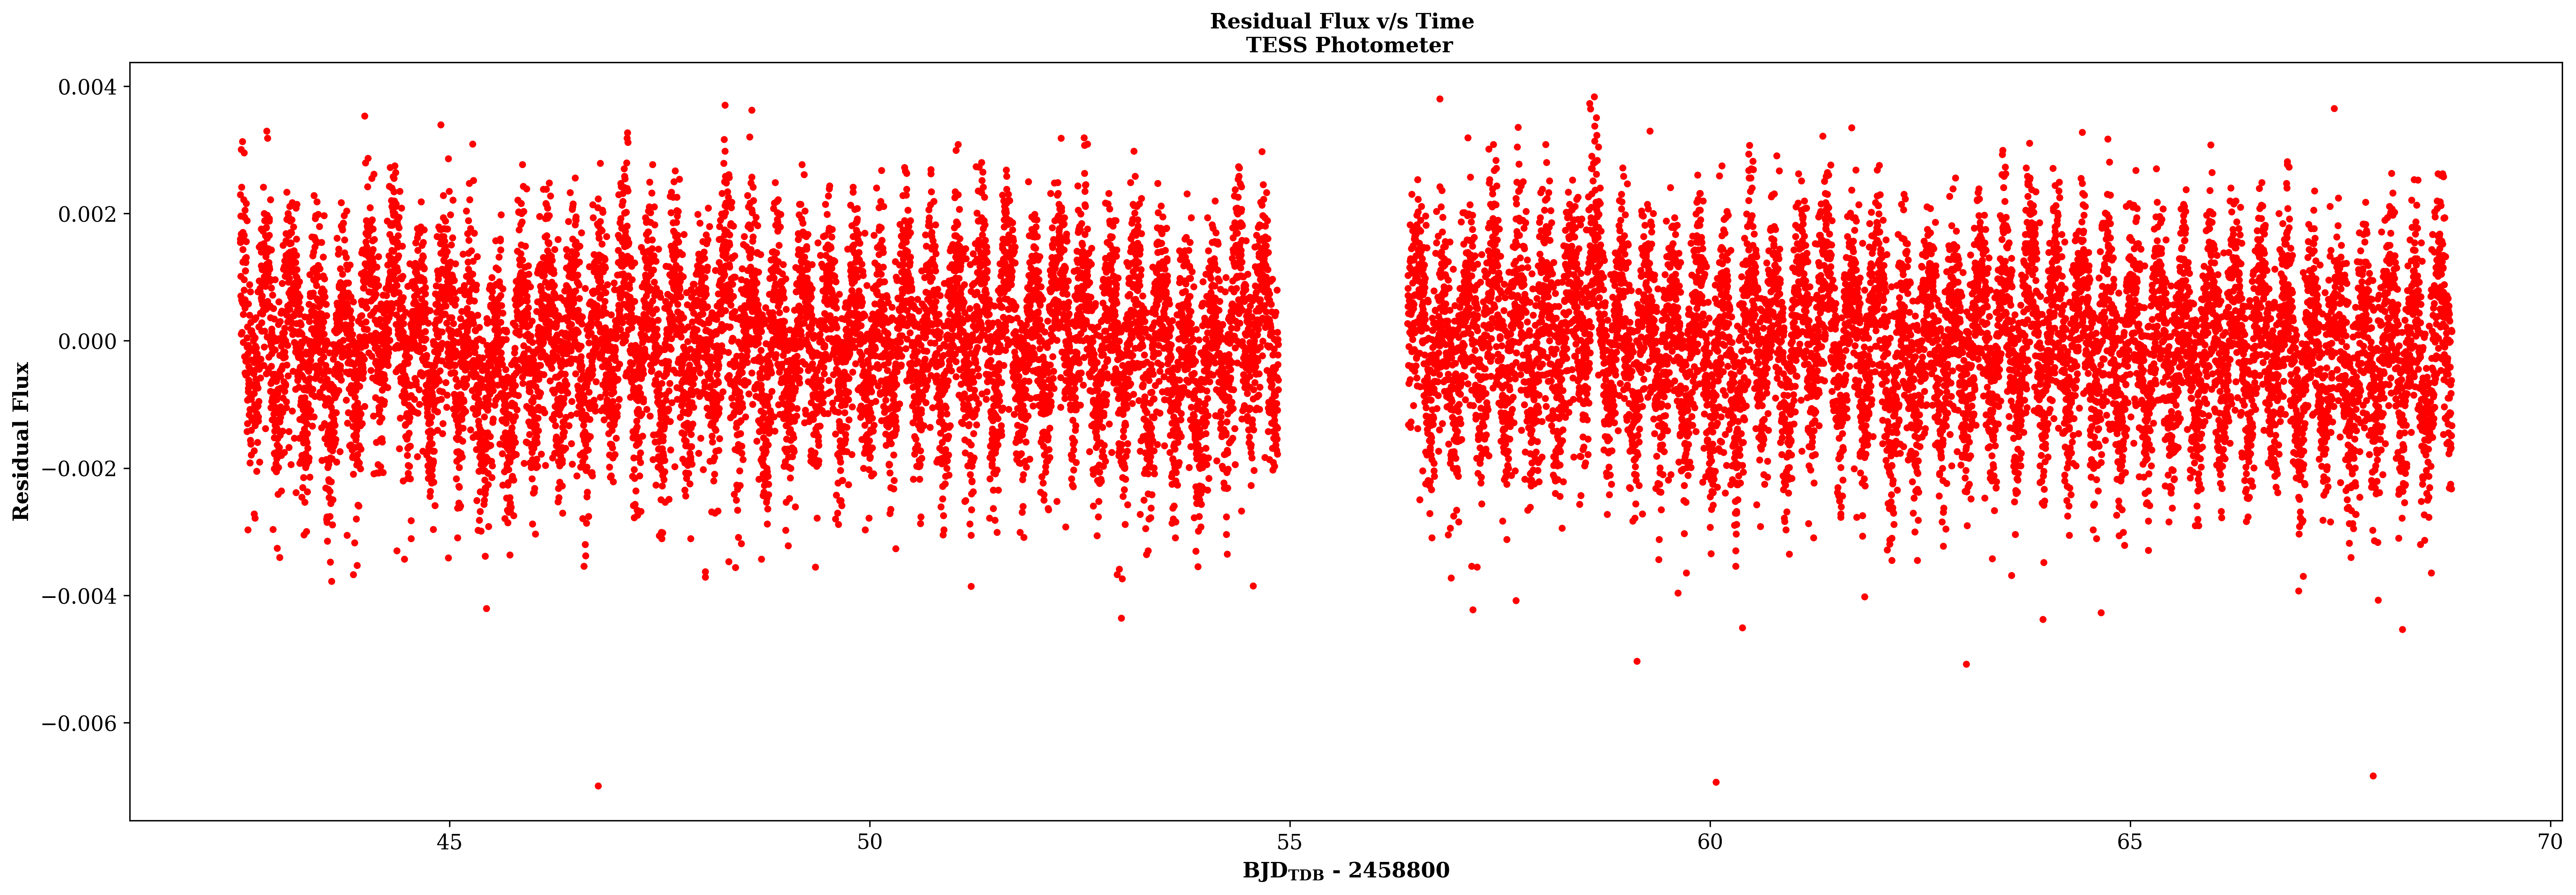

In [3]:
# Plot Residual Fluxes v/s Time Lightcurve
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')
fig, ax = plt.subplots(figsize = (25,8))
ax.plot(time_new - 2458800, flux_residuals, 'r.')
ax.set_xlabel(r'BJD$\mathregular{_{TDB}}$ - 2458800', fontsize='large', fontweight='bold')
ax.set_ylabel('Residual Flux', fontsize='large', fontweight='bold')
ax.set_title('Residual Flux v/s Time \n TESS Photometer', fontsize='large', fontweight='bold')
#plt.xlim(51,53)
#plt.savefig('HD219666b_mcmc_fit.png', overwrite = True)
plt.show()

3.2867520315559378


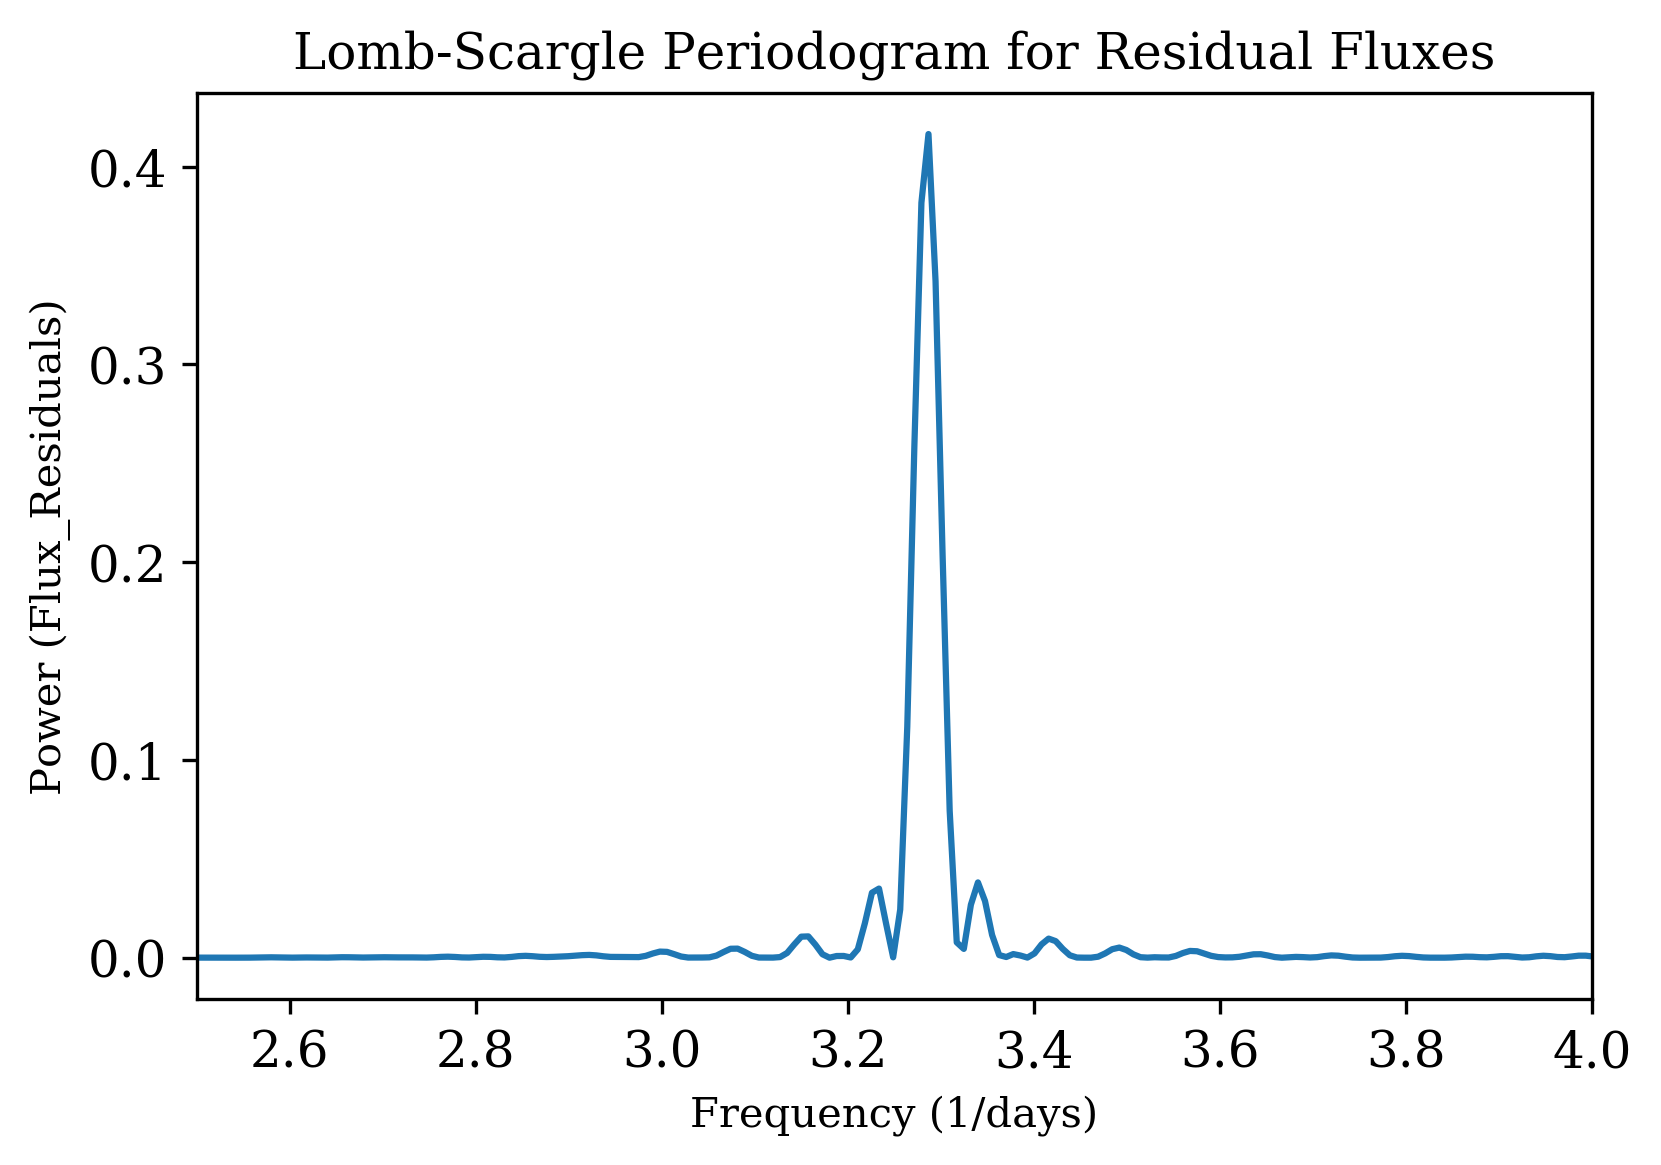

In [4]:
# Plot Lomb-Scargle Periodogram
frequency, power = LombScargle(time_new, flux_residuals).autopower()
plt.plot(frequency,power)
plt.gca().set(xlabel='Frequency (1/days)', ylabel='Power (Flux_Residuals)', title='Lomb-Scargle Periodogram for Residual Fluxes')
plt.xlim(2.5,4)
pmax = np.argmax(power)
fideal = frequency[pmax]
print(fideal)

## Pulsation Model
- Define Initial Parameters for Pulsation
- Define Pulsation Model
- Create Array for Pulsation Fluxes
- Plot Residual Fluxes v/s Time Lightcurve with Pulsation Fluxes

In [17]:
# Define Initial Parameters for Pulsation
pars_puls = np.zeros(3)
pars_puls[0] = 0.0025                   # Pulsation Amplitude
pars_puls[1] = 0.304                    # Pulsation Period
pars_puls[2] = 3.130                   # Pulsation Phase

In [18]:
# Define Pulsation Model
def pulsation(pars_puls, time):
    sine = pars_puls[0]*np.sin(2*np.pi*(time/pars_puls[1])+pars_puls[2])
    return sine 

In [19]:
# Create Array for Pulsation Fluxes
rel_flux_puls = pulsation(pars_puls, time_new)

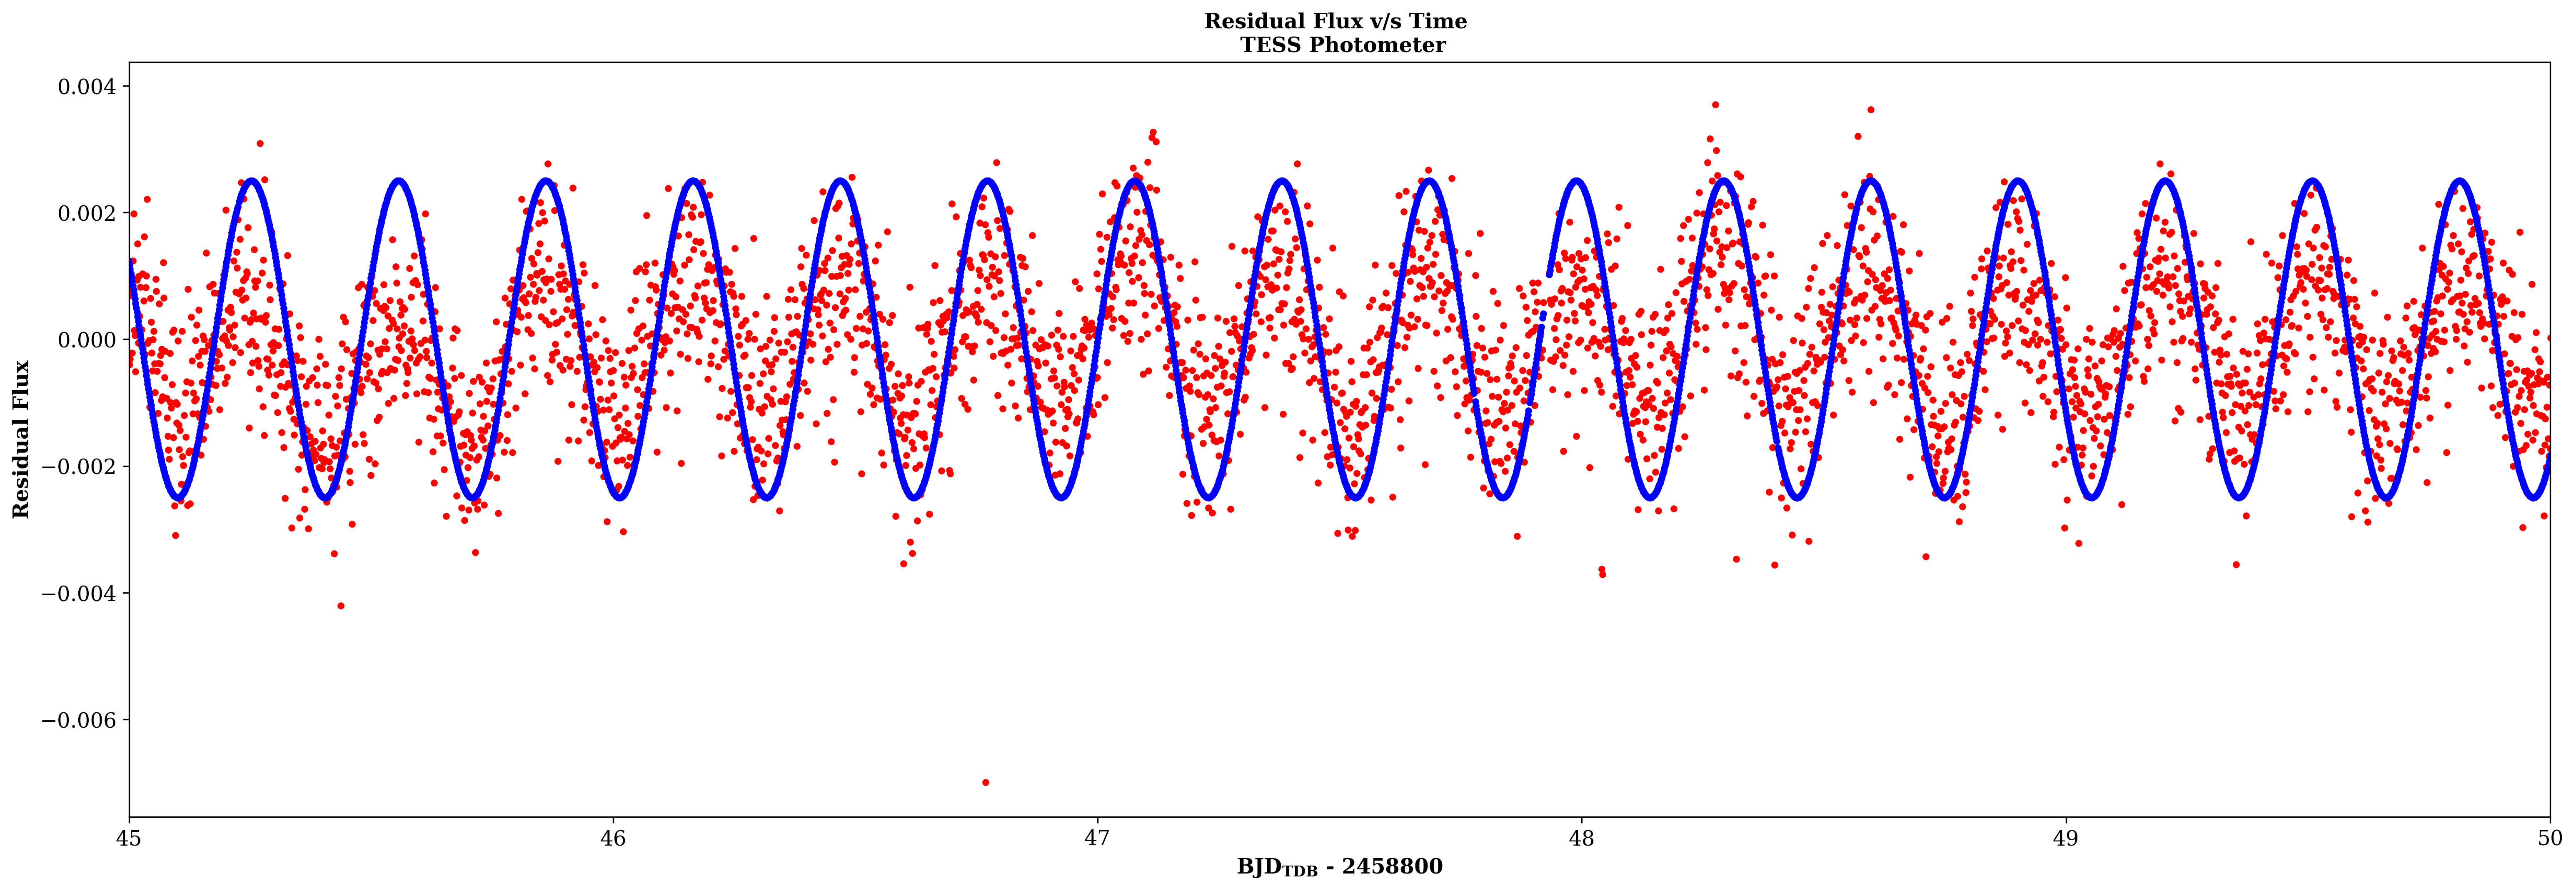

In [20]:
# Plot Residual Fluxes v/s Time Lightcurve with Pulsation Fluxes
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')
fig, ax = plt.subplots(figsize = (25,8))
ax.plot(time_new - 2458800, flux_residuals, 'r.', zorder=0)
ax.plot(time_new - 2458800, rel_flux_puls, 'b.', zorder=1)
ax.set_xlabel(r'BJD$\mathregular{_{TDB}}$ - 2458800', fontsize='large', fontweight='bold')
ax.set_ylabel('Residual Flux', fontsize='large', fontweight='bold')
ax.set_title('Residual Flux v/s Time \n TESS Photometer', fontsize='large', fontweight='bold')
plt.xlim(45,50)
#plt.savefig('HD219666b_mcmc_fit.png', overwrite = True)
plt.show()

## MCMC on Pulsation Observations
- Define log_likelihood Function
- MCMC (Burn+Production) Runs
- sampler.lnprobability 
- sampler.chain.shape Plots - To Check Parameter Values for Each Walker (1-10)
- sampler.flatchain.shape Plots - To Check Parameter Values for All Walkers (Walkers*Iterations)
- sampler.flatchain.shape Histograms - To Check Probability Distribution
- Median Value + Error for $A$
- Median Value + Error for $P_{pulsation}$
- Median Value + Error for $\theta_{pulsation}$

In [21]:
# Define log_likelihood Function
def log_likelihood_puls(pars_puls, x, y, yerr):
    #if pars_puls[0]< 0:
        #return -np.inf
    #if pars_puls[1]< 0.25 or pars_puls[1]>0.35:
        #return -np.inf
    #if pars_puls[2]<math.pi/2 or pars_puls[2]>3*math.pi/2: 
        #return -np.inf
    model =  pulsation(pars_puls,x)
    sigma = yerr
    lnprobmodel = -0.5 * np.sum(((y - model) ** 2. / sigma ** 2.) + np.log(2. * math.pi * sigma ** 2.))
    return lnprobmodel

In [22]:
# MCMC (Burn+Production) Runs
nwalkers = 6
ndim = 3
scales = np.zeros(3)
scales[0] = 0.001           # Pulsation Amplitude
scales[1] = 0.001            # Pulsation Period                  
scales[2] = 0.01            # Pulsation Phase                    
pos = emcee.utils.sample_ball(pars_puls, scales, nwalkers)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_puls, args=(time_new, flux_residuals, rel_flux_err_new))
print("Running burn-in...")
pos,_,_ = sampler.run_mcmc(pos, 2000, progress=True);
sampler.reset()
print("Running production...")
pos,_,_ = sampler.run_mcmc(pos, 10000, progress=True);
print(pos)

  1%|          | 15/2000 [00:00<00:13, 148.61it/s]

Running burn-in...


  0%|          | 16/10000 [00:00<01:03, 157.08it/s]

Running production...


100%|██████████| 10000/10000 [01:03<00:00, 156.52it/s]

[[ 1.06438908e-03  3.04358796e-01  3.09647208e+00]
 [-3.15468843e-04  2.99380781e-01  3.06381568e+00]
 [ 3.33357446e-04  2.99405953e-01  3.08367845e+00]
 [ 1.09031740e-03  3.04383324e-01  3.09731735e+00]
 [ 1.06873129e-03  3.04388260e-01  3.09429528e+00]
 [ 1.06826925e-03  3.04337399e-01  3.09831429e+00]]


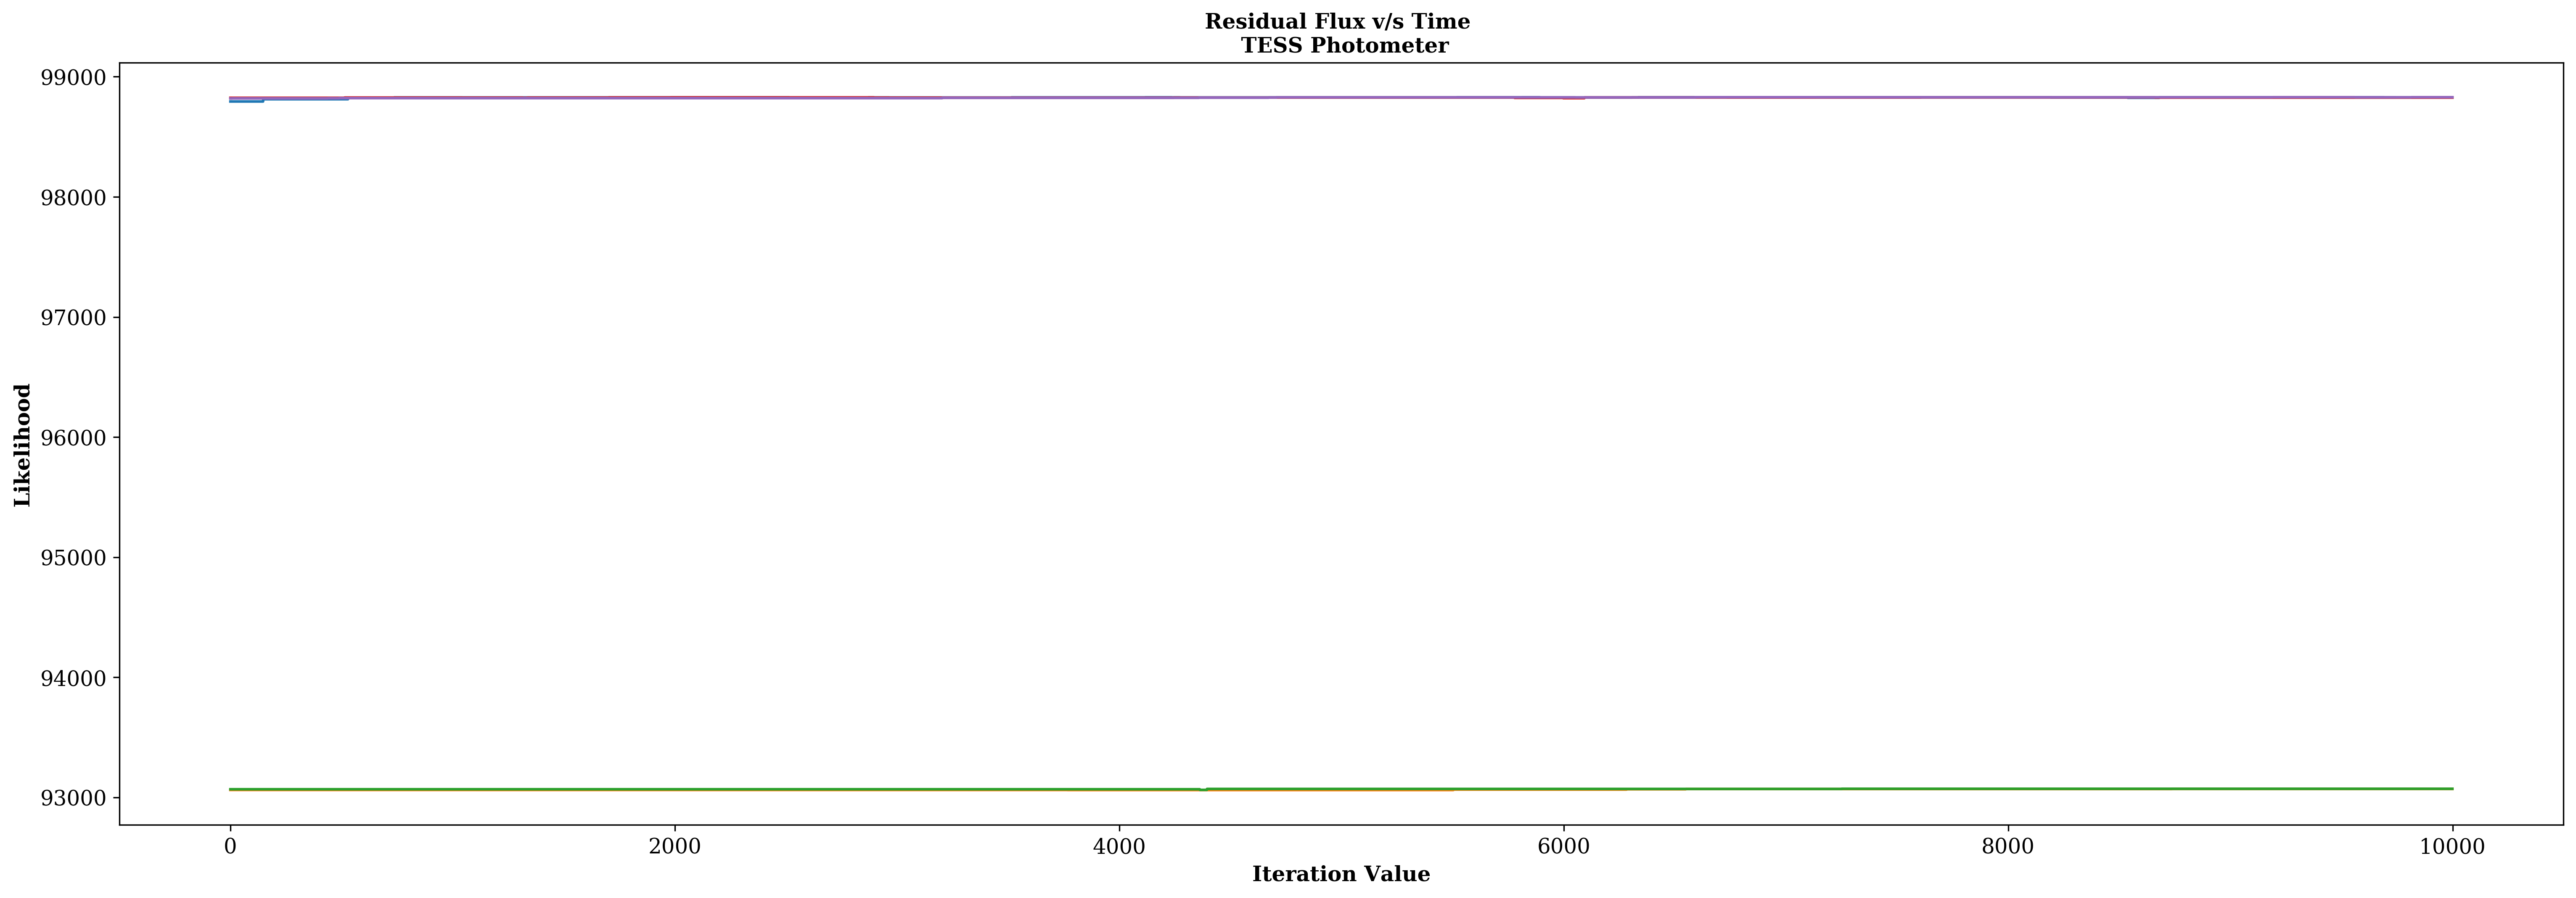

In [23]:
# sampler.lnprobability
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')
fig, ax = plt.subplots(figsize = (25,8))
ax.plot(sampler.lnprobability[0,:])
ax.plot(sampler.lnprobability[1,:])
ax.plot(sampler.lnprobability[2,:])
ax.plot(sampler.lnprobability[3,:])
ax.plot(sampler.lnprobability[4,:])
ax.set_xlabel('Iteration Value', fontsize='large', fontweight='bold')
ax.set_ylabel('Likelihood', fontsize='large', fontweight='bold')
ax.set_title('Residual Flux v/s Time \n TESS Photometer', fontsize='large', fontweight='bold')
#plt.xlim(42,48)
#plt.savefig('HD219666b_mcmc_fit.png', overwrite = True)
plt.show()


/Users/astroarshn2000/anaconda3/envs/astro/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


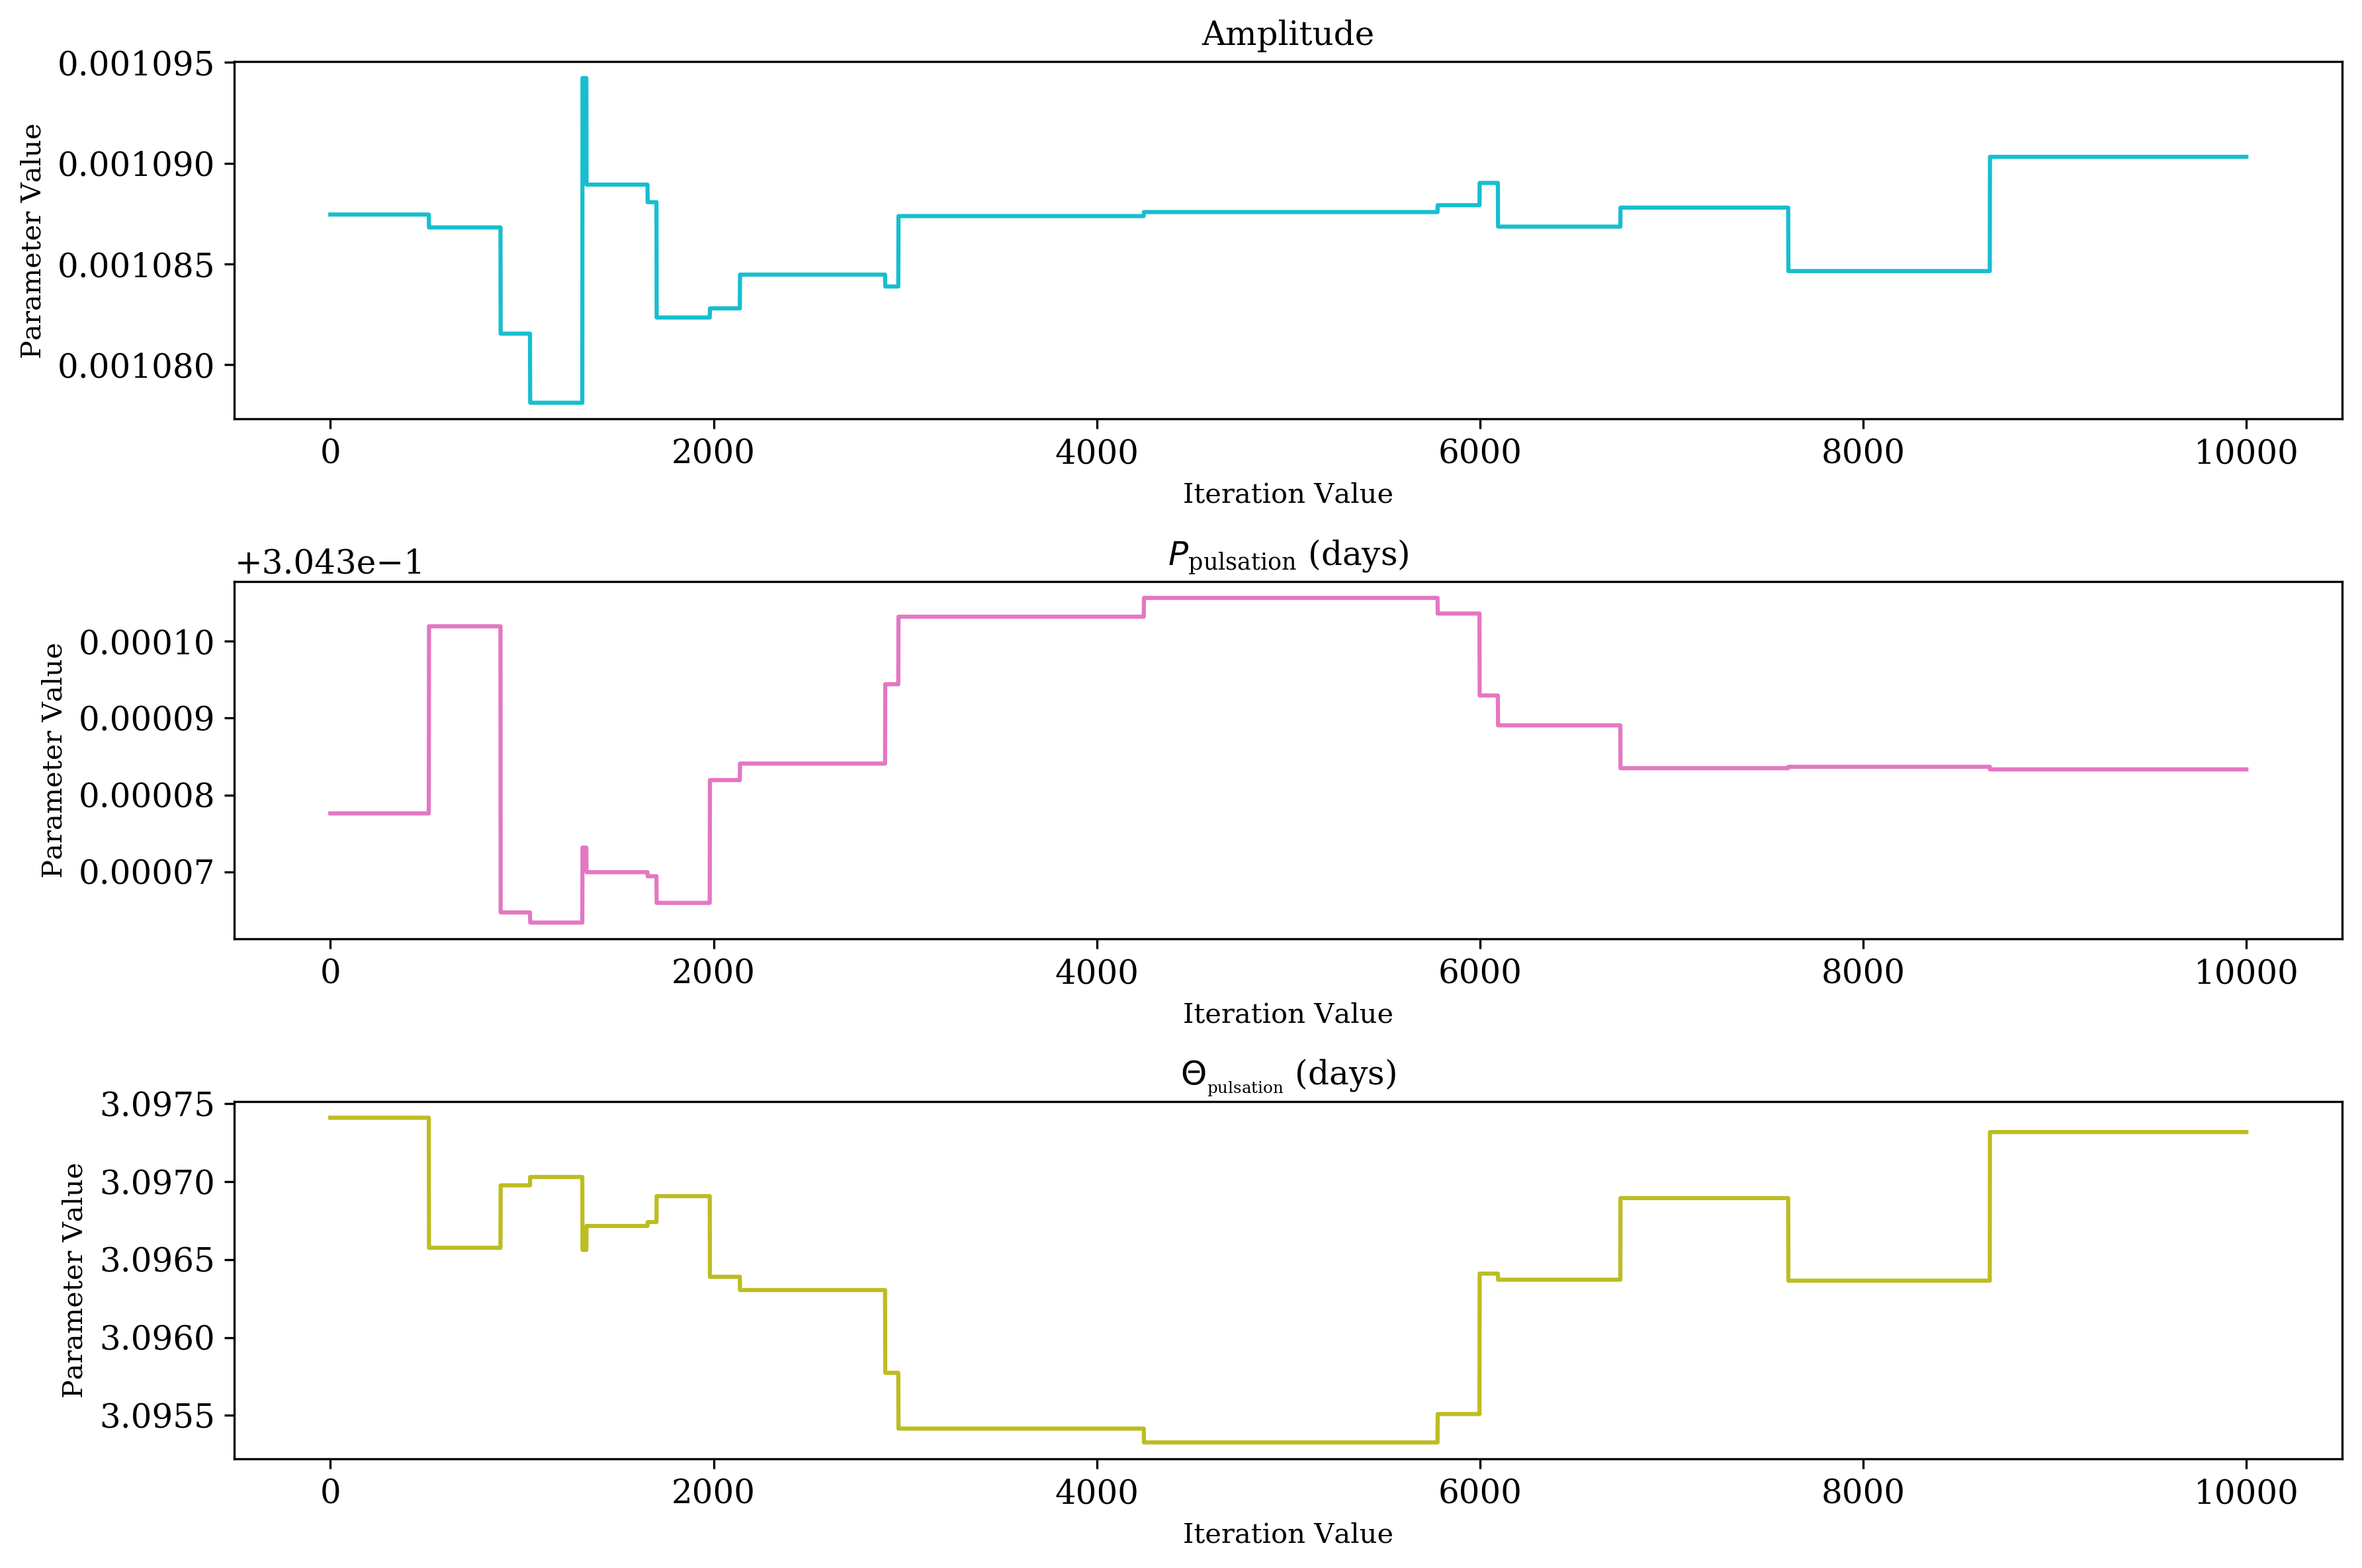

In [24]:
# sampler.chain.shape Plots - To Check Parameter Values for Each Walker (1-10)
fig, axs = plt.subplots(3, figsize=(12,8))
axs[0].plot(sampler.chain[3,:,0], 'tab:cyan')
axs[0].set_title('Amplitude')
axs[1].plot(sampler.chain[3,:,1], 'tab:pink')
axs[1].set_title('$P\mathregular{_{pulsation}}$ (days)')
axs[2].plot(sampler.chain[3,:,2], 'tab:olive')
axs[2].set_title('$\Theta_\mathregular{_{pulsation}}$ (days)')
for ax in axs.flat:
    ax.set(xlabel='Iteration Value', ylabel='Parameter Value')
fig.tight_layout()
fig.show()

/Users/astroarshn2000/anaconda3/envs/astro/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


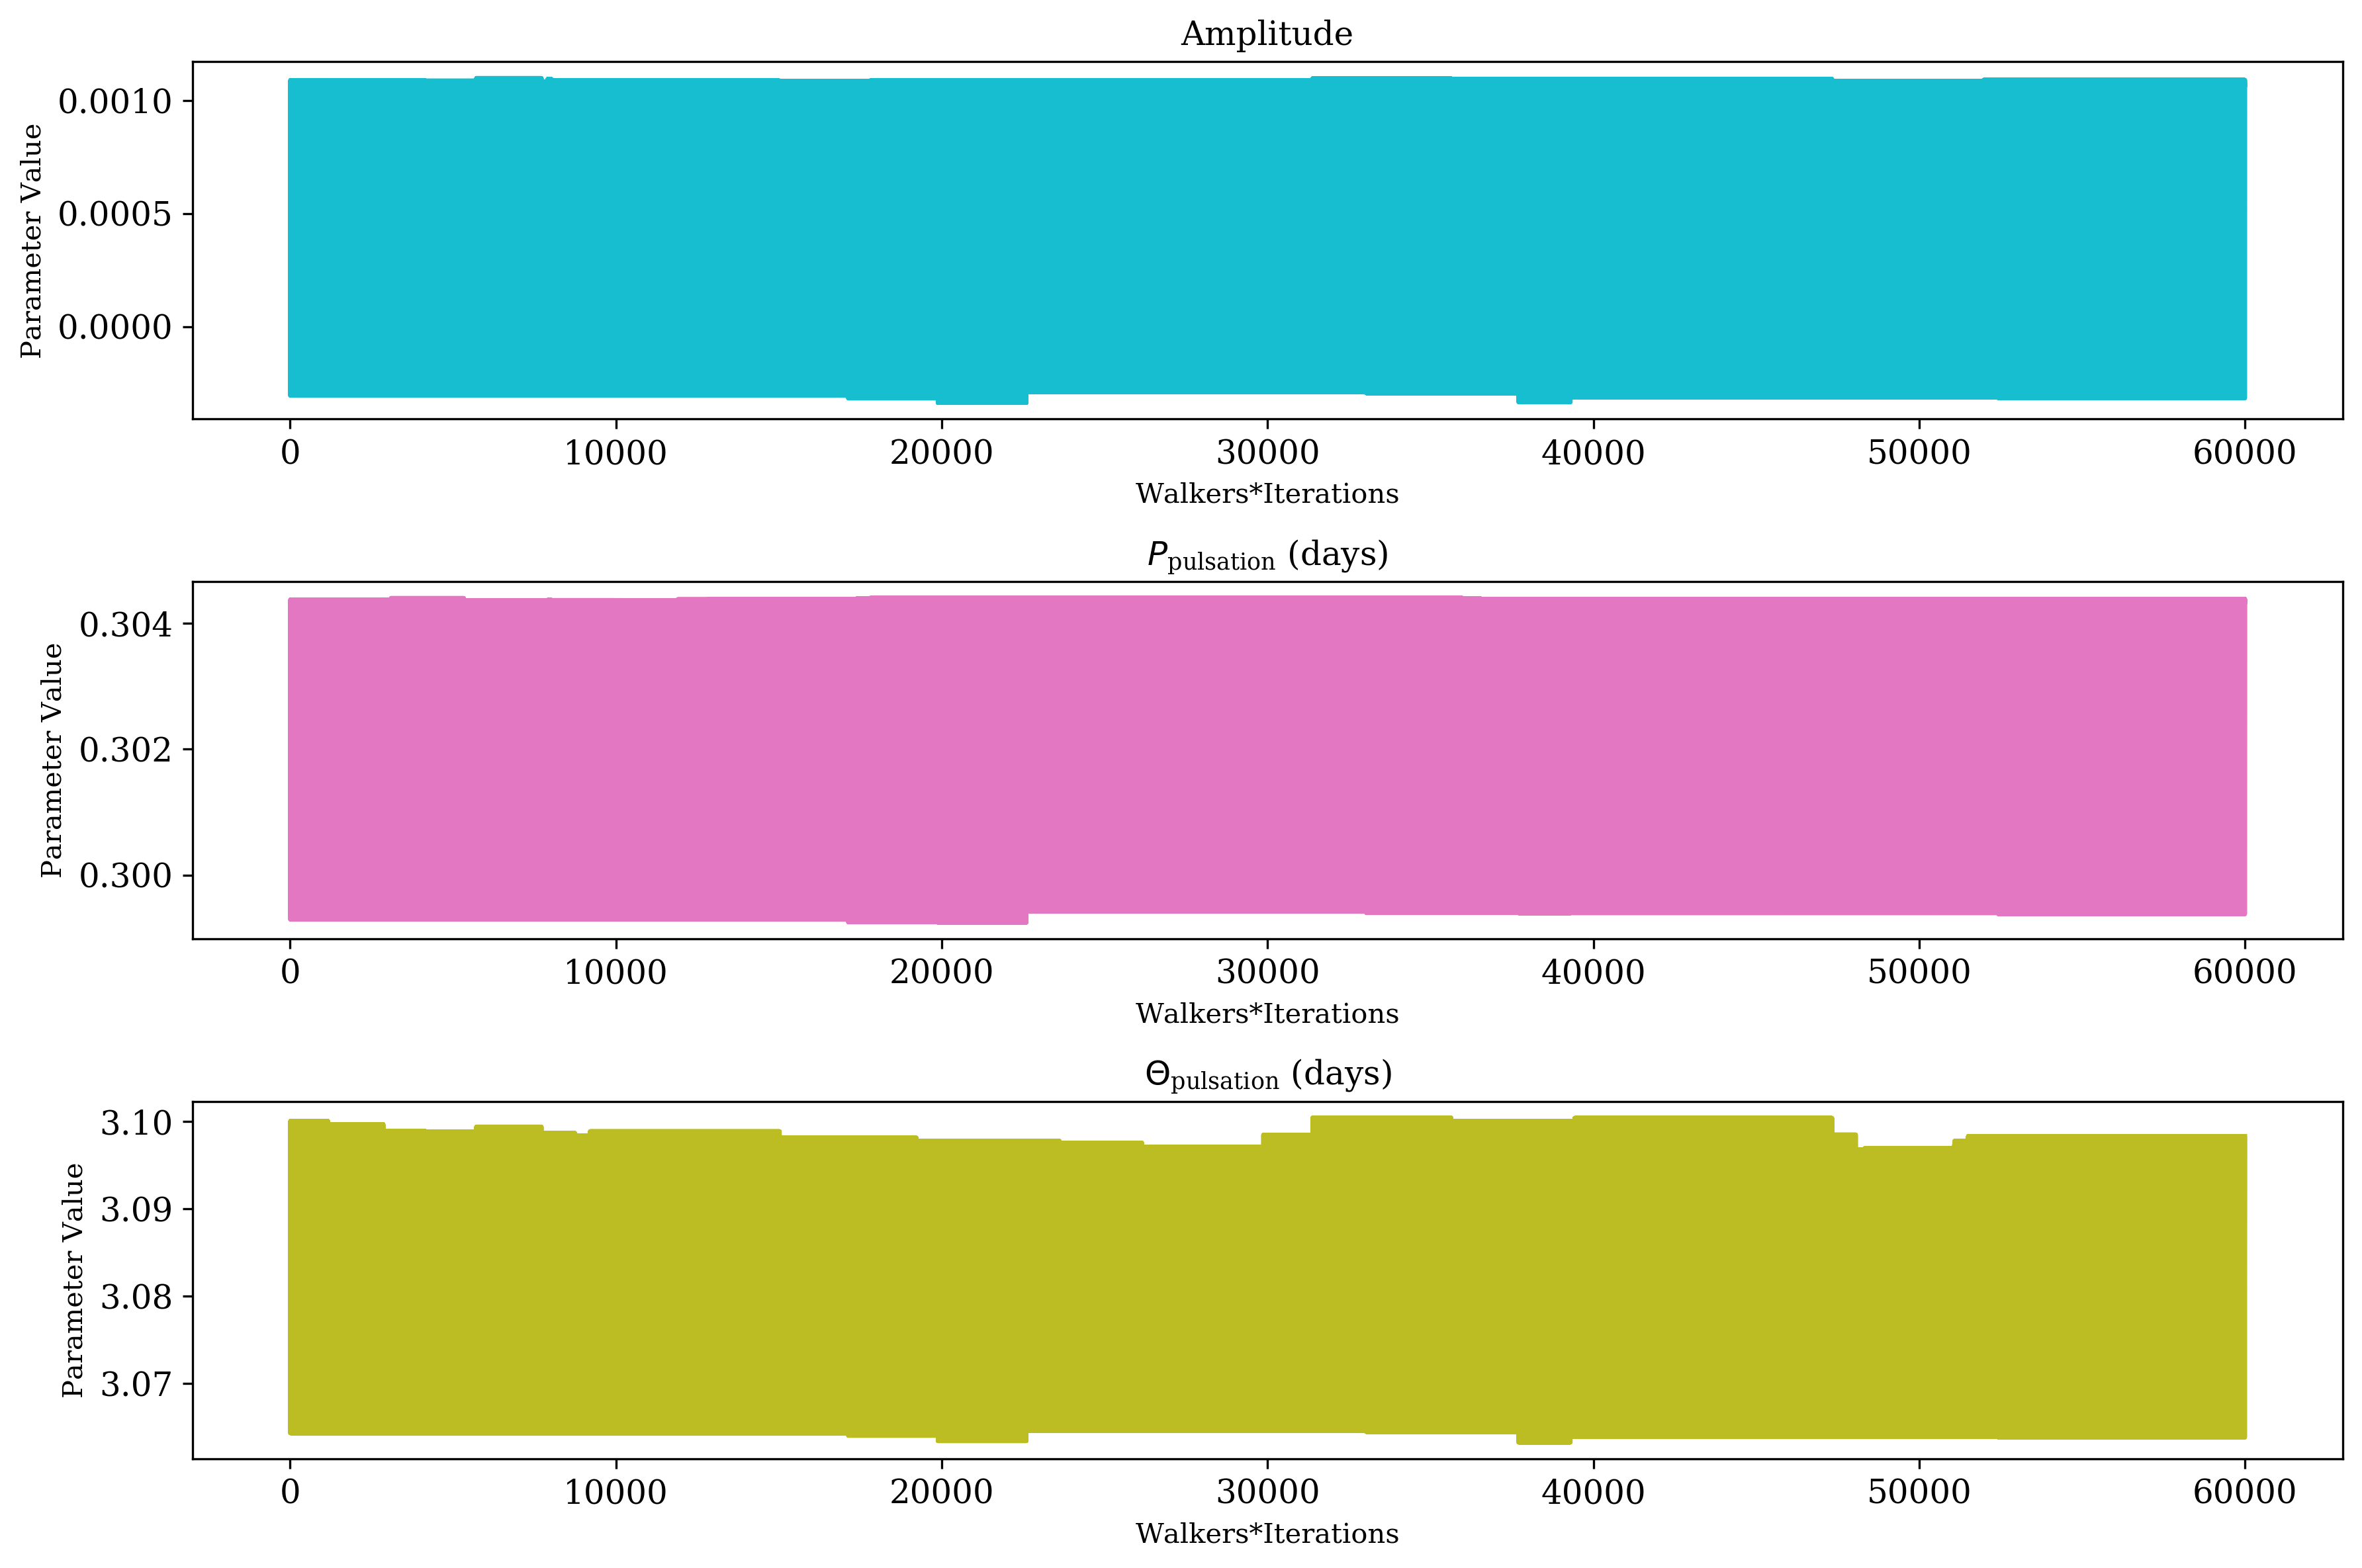

In [25]:
# sampler.flatchain.shape Plots - To Check Parameter Values for All Walkers (Walkers*Iterations)
fig, axs = plt.subplots(3, figsize=(12,8))
axs[0].plot(sampler.flatchain[:,0], 'tab:cyan')
axs[0].set_title('Amplitude')
axs[1].plot(sampler.flatchain[:,1], 'tab:pink')
axs[1].set_title('$P\mathregular{_{pulsation}}$ (days)')
axs[2].plot(sampler.flatchain[:,2], 'tab:olive')
axs[2].set_title('$\Theta\mathregular{_{pulsation}}$ (days)')
for ax in axs.flat:
    ax.set(xlabel='Walkers*Iterations', ylabel='Parameter Value')
fig.tight_layout()
fig.show()

/Users/astroarshn2000/anaconda3/envs/astro/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


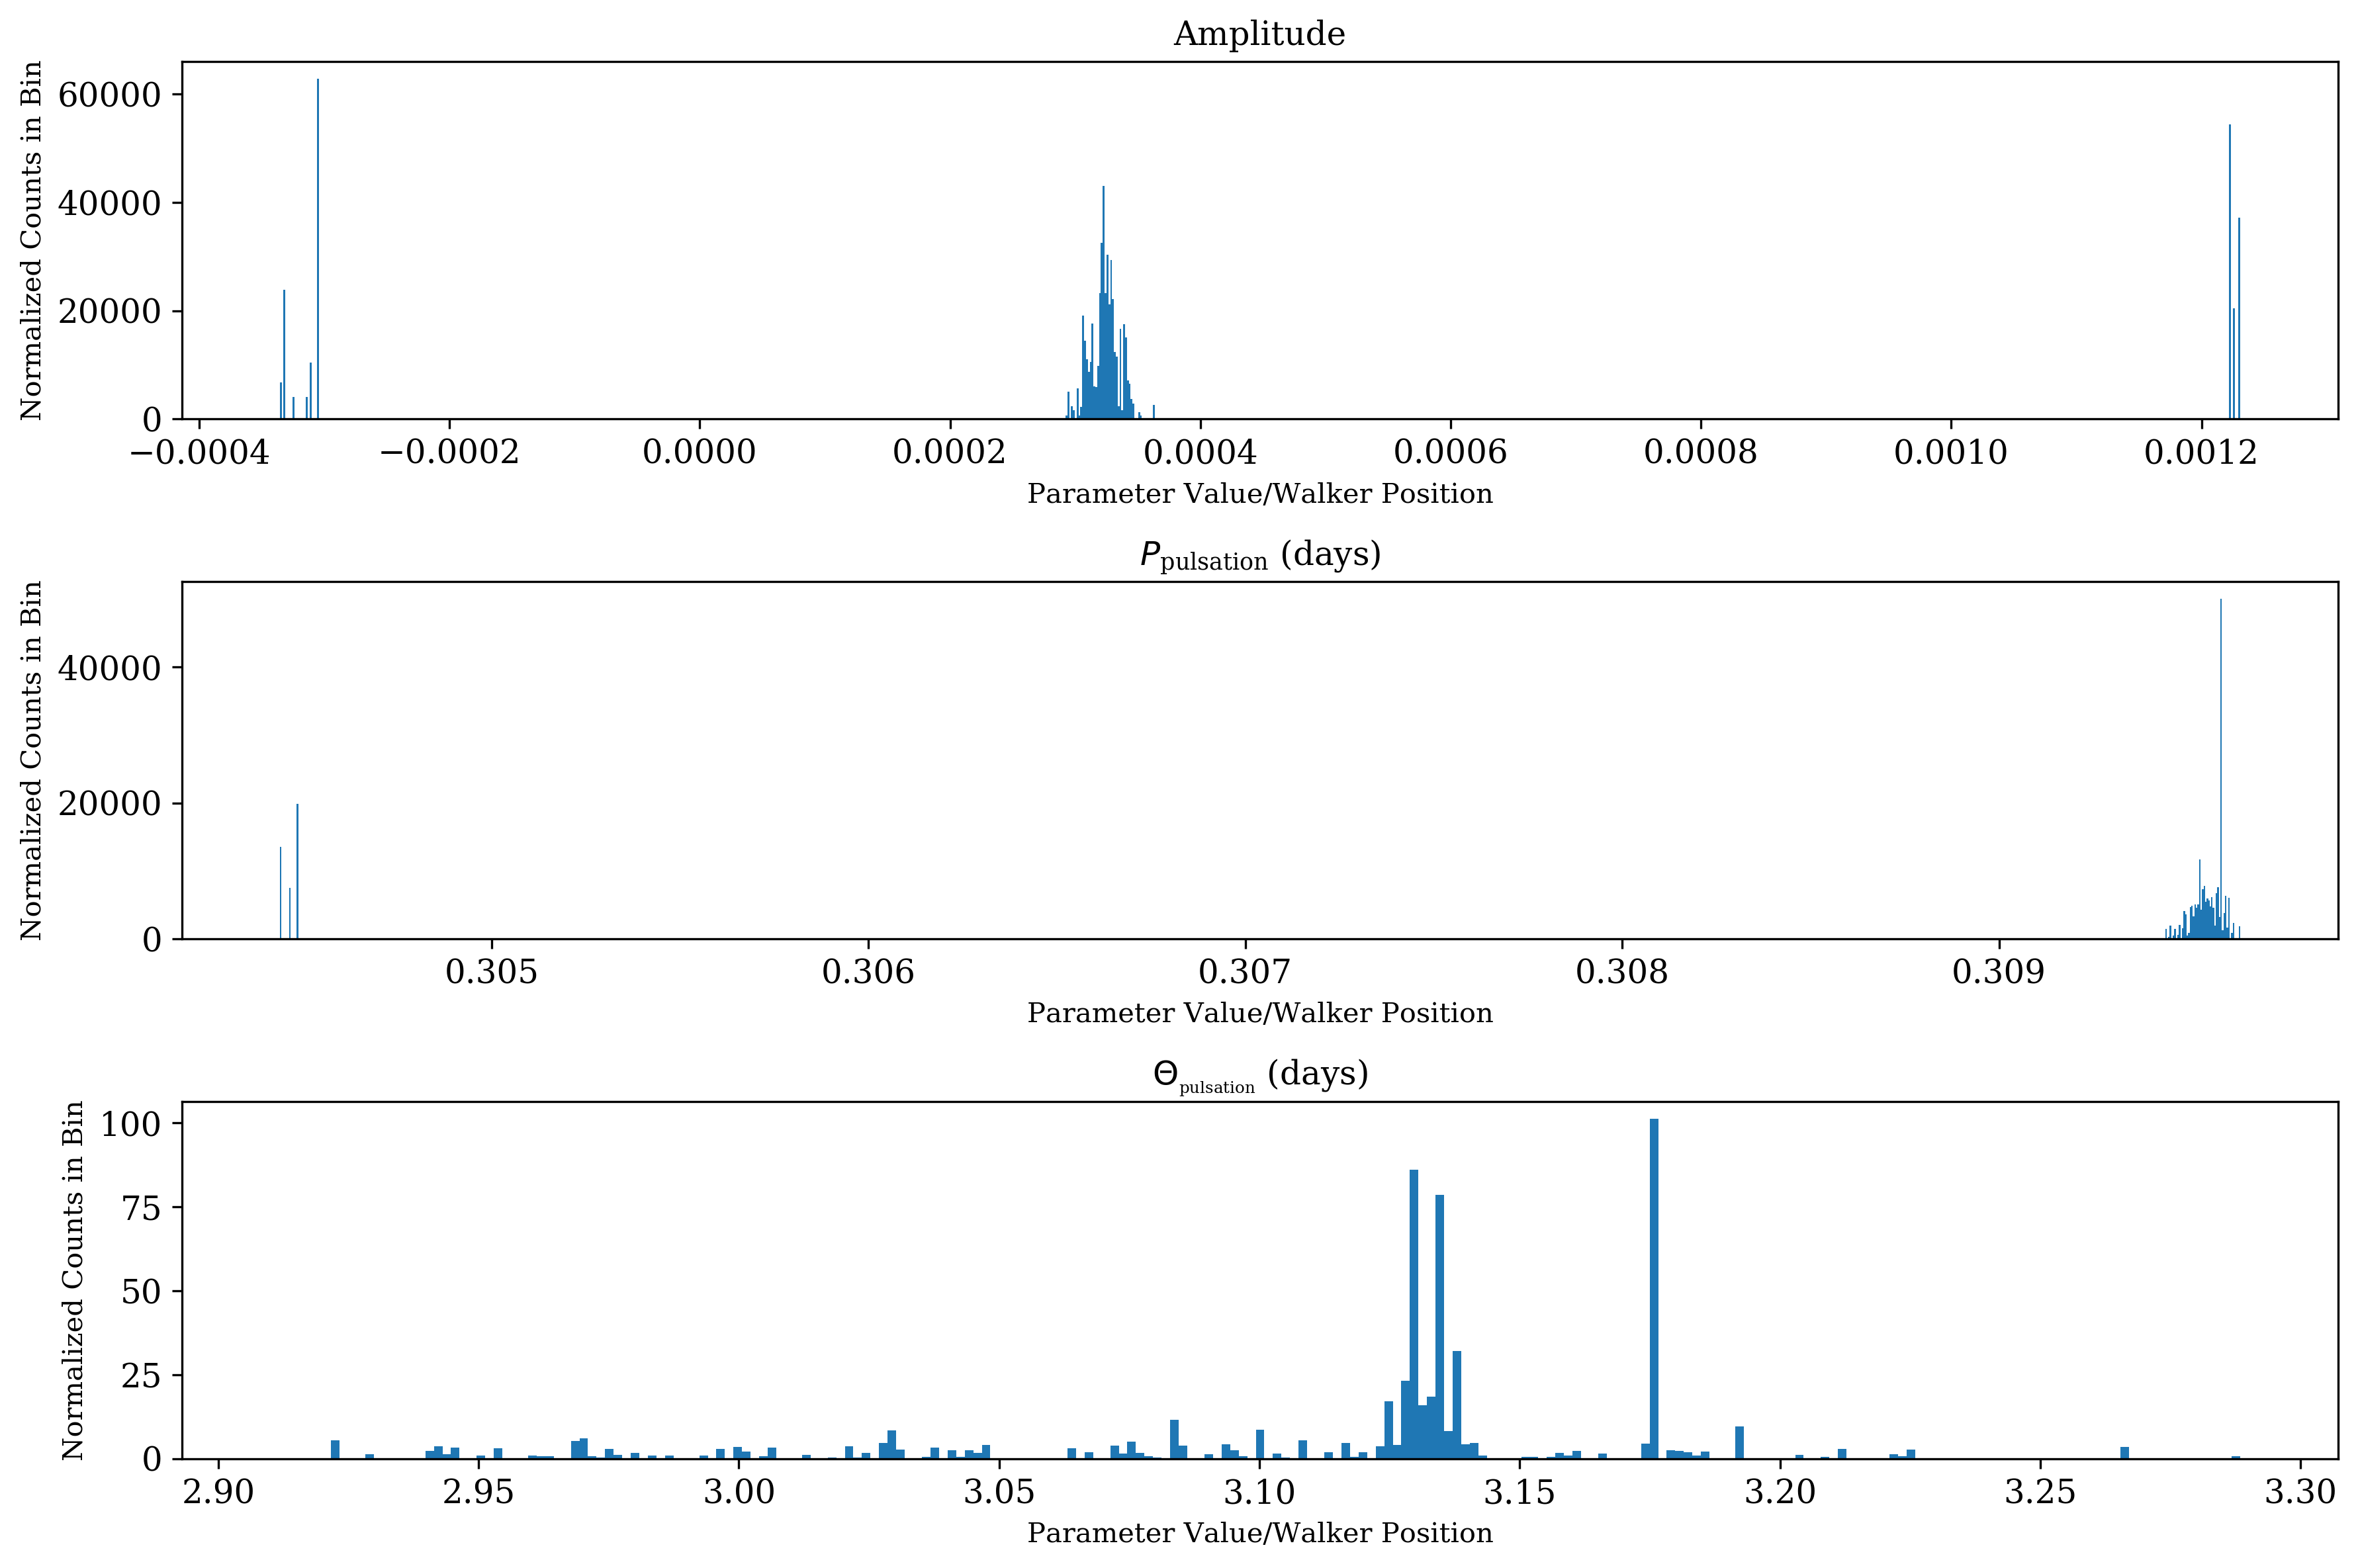

In [13]:
# sampler.flatchain.shape Histograms - To Check Probability Distribution
fig, axs = plt.subplots(3, figsize=(12,8))
axs[0].hist(sampler.flatchain[:,0], bins='auto', density = True)
axs[0].set_title('Amplitude')
axs[1].hist(sampler.flatchain[:,1], bins='auto', density = True)
axs[1].set_title('$P\mathregular{_{pulsation}}$ (days)')
axs[2].hist(sampler.flatchain[:,2], bins='auto', density = True)
axs[2].set_title('$\Theta_\mathregular{_{pulsation}}$ (days)')
for ax in axs.flat:
    ax.set(xlabel='Parameter Value/Walker Position', ylabel='Normalized Counts in Bin')
fig.tight_layout()
fig.show()

In [14]:
# Median Value + Error for A
medval_A = np.median(sampler.flatchain[:,0])
minus_A = medval_A - np.percentile(sampler.flatchain[:,0],16.0)
plus_A = np.percentile(sampler.flatchain[:,0],84.0)- medval_A
print(medval_A)
print(minus_A)
print(plus_A)

0.0003238656693008158
0.0006283100576525323
0.0008986702498794909


In [15]:
# Median Value + Error for P
medval_P = np.median(sampler.flatchain[:,1])
minus_P = medval_P - np.percentile(sampler.flatchain[:,1],16.0)
plus_P = np.percentile(sampler.flatchain[:,1],84.0)- medval_P
print(medval_P)
print(minus_P)
print(plus_P)

0.30954920583681367
0.005064187361877914
4.047516277438934e-05


In [16]:
# Median Value + Error for Theta
medval_theta = np.median(sampler.flatchain[:,2])
minus_theta = medval_theta - np.percentile(sampler.flatchain[:,2],16.0)
plus_theta = np.percentile(sampler.flatchain[:,2],84.0)- medval_theta
print(medval_theta)
print(minus_theta)
print(plus_theta)

3.1308438168526647
0.06765909678771775
0.044540754359455814


In [ ]:
figure = corner.corner(sampler.flatchain, 
                       labels=["Amplitude","$P\mathregular{_{pulsation}}$ (days)","$\Theta_\mathregular{_{pulsation}}$ (days)"], 
                       label_kwargs=dict(fontsize=9),
                       #truths=[pars_fit[0], pars_fit[1], pars_fit[2], pars_fit[3], pars_fit[4]],
                       truth_color='#ff0000',
                       quantiles=[0.16, 0.5, 0.84], 
                       top_ticks=True,
                       verbose=False)

## Minimization

In [ ]:
# Define Minimization Function 
def minimize_fn(pars_puls, x, y, yerr):
    return -1*log_likelihood_puls(pars_puls, x, y, yerr)

In [ ]:
InitMinArr = minimize(minimize_fn, pars_puls, args=(time_new, flux_residuals, rel_flux_err_new), method='Nelder-Mead', options={'maxiter': 10000, 'maxfev': 5000, 'disp': True})
InitMin = InitMinArr.x
print(InitMin)

## Residuals

In [ ]:
# Create Flux Residuals Array
sine_residuals = rel_flux_puls-flux_residuals

In [ ]:
# Plot a Histogram for Sine Residuals
mean,std=norm.fit(sine_residuals)
plt.hist(sine_residuals, bins='auto', density = True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.plot(x, y)
plt.gca().set(xlabel='Sine Residual Flux (Relative)', ylabel='Normalized Counts in Bin', title='Residuals for Pulsation Model Fit')
#plt.savefig('flux_residuals_HD219666b.png', overwrite = True)
plt.show()

In [ ]:
# Plot Lomb-Scargle Periodogram
frequency, power = LombScargle(time_new, sine_residuals).autopower()
plt.plot(frequency,power)
plt.gca().set(xlabel='Frequency (1/days)', ylabel='Power (Sine_Residuals)', title='Lomb-Scargle Periodogram for Pulsation Residual Fluxes')
plt.xlim(2.5,4)
pmax = np.argmax(power)
fideal = frequency[pmax]
print(fideal)

In [ ]:
# Plot Residual Fluxes v/s Time Lightcurve
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')
fig, ax = plt.subplots(figsize = (25,8))
ax.plot(time_new - 2458800, sine_residuals, 'r.')
ax.set_xlabel(r'BJD$\mathregular{_{TDB}}$ - 2458800', fontsize='large', fontweight='bold')
ax.set_ylabel('Pulsation Residual Flux', fontsize='large', fontweight='bold')
ax.set_title('Residual Flux v/s Time \n TESS Photometer', fontsize='large', fontweight='bold')
#plt.xlim(51,53)
#plt.savefig('HD219666b_mcmc_fit.png', overwrite = True)
plt.show()